In [1]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.8 MB/s eta 0:00:00


In [2]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.8.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.1
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-iers-data                     0.2025.6.23.0.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

In [4]:
df = pd.read_csv("All_data_curated.csv", sep=";")
print(df.head())

      dbAMP_ID                                       Seq  Sequence_Length  \
0  dbAMP_00005  AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC               40   
1  dbAMP_00024                         AAFRGCWTKNYSPKPCL               17   
2  dbAMP_00028                                AAGMGFFGAR               10   
3  dbAMP_00032                                AAHCLAIGRR               10   
4  dbAMP_00037                         AAKIILNPKFRCKAAFC               17   

  Min_MIC_gram_positive Max_MIC_gram_positive Min_MIC_gram_negative  \
0                 22,64                 22,64                  7,66   
1                 57,55                114,87                   NaN   
2                 14,56                 29,12                 14,56   
3                     5                 18,44                 18,44   
4                139,68                139,68                 69,84   

  Max_MIC_gram_negative min_mic_total max_mic_total  
0                  7,66          7,66         22,64  
1 

In [5]:
df = df.dropna(subset=["Seq", "max_mic_total"]).copy()

df.loc[:, "Seq"] = df["Seq"].str.strip()
df = df[df["Seq"] != ""]
df.loc[:, "max_mic_total"] = df["max_mic_total"].astype(str).str.replace(",", ".").astype(float)

standard_aa = set("ACDEFGHIKLMNPQRSTVWY")
df = df[df["Seq"].apply(lambda seq: all(aa in "ACDEFGHIKLMNPQRSTVWY" for aa in seq))]

df = df[df["Seq"].apply(lambda x: 5 <= len(x) <= 50)]

#Dropping duplicates
df = df.drop_duplicates(subset="Seq")

Number of sequences after general preprocessing: 8922


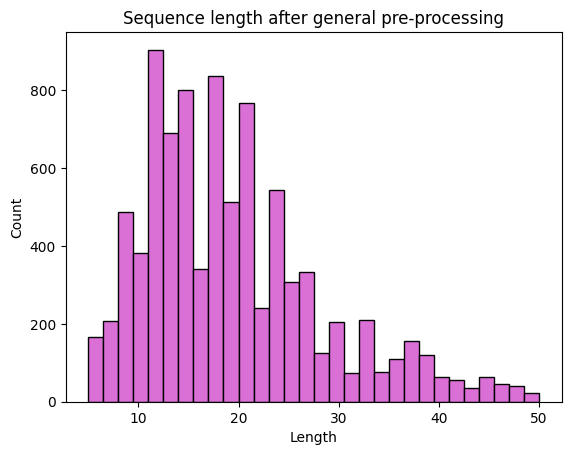

In [10]:
print("Number of sequences after general preprocessing:", len(df))

plt.hist(df["Seq"].apply(len), bins=30, color="orchid", edgecolor="black")
plt.title("Sequence length after general pre-processing")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

In [7]:
df["AMP"] = (df["max_mic_total"] < 32).astype(int)

Number of positive AMPs: 3724


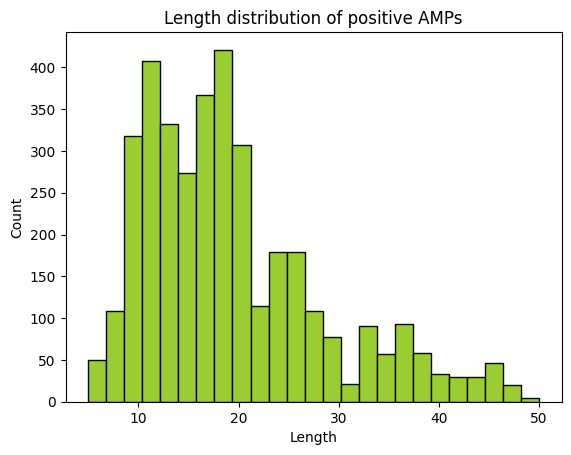

Number of negative AMPs: 5198


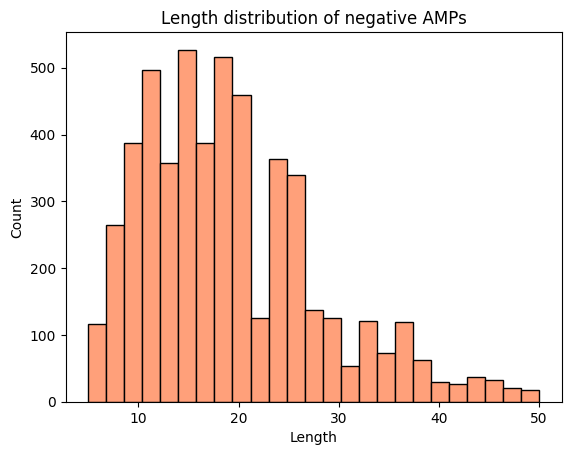

In [11]:
amp1_count = len(df[df["AMP"] == 1])
print(f"Number of positive AMPs: {amp1_count}")

plt.hist(df[df["AMP"] == 1]["Seq"].apply(len), bins=25, color="yellowgreen", edgecolor="black")
plt.title("Length distribution of positive AMPs")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()


amp0_count = len(df[df["AMP"] == 0])
print(f"Number of negative AMPs: {amp0_count}")
plt.hist(df[df["AMP"] == 0]["Seq"].apply(len), bins=25, color="lightsalmon", edgecolor="black")
plt.title("Length distribution of negative AMPs")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

In [9]:
# Writing DataFrame to FASTA
def df_to_fasta(df_subset, filename):
    records = [
        SeqRecord(
            Seq(row["Seq"]),
            id=f"{row['dbAMP_ID']}|AMP={row['AMP']}",
            description=""
        )
        for _, row in df_subset.iterrows()
    ]
    SeqIO.write(records, filename, "fasta")

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["AMP"], random_state=42)

df_to_fasta(train_df, "AMP_train.fasta")
df_to_fasta(test_df, "AMP_test.fasta")
df_to_fasta(df, "AMP_full.fasta")

print(f"Total: {len(df)} | Train: {len(train_df)} | Test: {len(test_df)}")

Total: 8922 | Train: 7137 | Test: 1785
